In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import NearestNeighbors

warnings.filterwarnings("ignore", category=UserWarning)

## **CLEANING/PREPROCCESSING**

THIS IS THE ORIGINAL METADAT DF THAT PROVIDED US WITH BOOK IDS, TITLE, ISBN, AUTHOR & RATING. I DROPPED COLUMNS THAT I FELT HAD NO CORRELATION OR SIGNIFICANCE IN BUILDING THE BOOK RECOMMENDATION SYSTEM; CHECK FOR NULL VALUES, DROP THE NULL VALUES.

In [2]:
file_path = "/Users/medirose/Downloads/archive (9)/books.csv"

df = pd.read_csv(file_path)

In [3]:
df.drop(['isbn13', 'image_url', 'small_image_url', 'ratings_1',	'ratings_2', 'ratings_3',	'ratings_4',	'ratings_5', 'title', 'best_book_id', 'work_id', 'work_ratings_count', 'work_text_reviews_count', 'average_rating'], axis=1, inplace=True)
df

,book_id,goodreads_book_id,books_count,isbn,authors,original_publication_year,original_title,language_code,ratings_count
0,1,2767052,272,439023483,Suzanne Collins,2008.0,The Hunger Games,eng,4780653
1,2,3,491,439554934,"J.K. Rowling, Mary GrandPré",1997.0,Harry Potter and the Philosopher's Stone,eng,4602479
2,3,41865,226,316015849,Stephenie Meyer,2005.0,Twilight,en-US,3866839
3,4,2657,487,61120081,Harper Lee,1960.0,To Kill a Mockingbird,eng,3198671
4,5,4671,1356,743273567,F. Scott Fitzgerald,1925.0,The Great Gatsby,eng,2683664
...,...,...,...,...,...,...,...,...,...
9995,9996,7130616,19,441019455,Ilona Andrews,2010.0,Bayou Moon,eng,17204
9996,9997,208324,19,067973371X,Robert A. Caro,1990.0,Means of Ascent,eng,12582
9997,9998,77431,60,039330762X,Patrick O'Brian,1977.0,The Mauritius Command,eng,9421
9998,9999,8565083,7,61711527,Peggy Orenstein,2011.0,Cinderella Ate My Daughter: Dispatches from th...,eng,11279


In [4]:
df.isnull().sum()

book_id                         0
goodreads_book_id               0
books_count                     0
isbn                          700
authors                         0
original_publication_year      21
original_title                585
language_code                1084
ratings_count                   0
dtype: int64

In [5]:
df = df.dropna().copy()

THIS IS THE DATASET THAT PROVIDED OF 6M RATINGS FOR USER ID & BOOK ID. BECAUSE THE DATA WAS SO LARGE, I DECIDED TO ONLY TAKE A CHUNK (100K) SO THAT IT WOULD BE EASIER TO MANAGE AND RUN OTHER CODES WITH.

In [6]:
# Define file path and chunk size
file_path2 = "/Users/medirose/Downloads/archive (9)/ratings.csv"
chunk_size = 100000

# Initialize an iterator for 'ratings' dataset
ratings_iter = pd.read_csv(file_path2, chunksize=chunk_size)

# Iterate over chunks of 'ratings' dataset
for chunk in ratings_iter:
    print(chunk.head())

   user_id  book_id  rating
0        1      258       5
1        2     4081       4
2        2      260       5
3        2     9296       5
4        2     2318       3
        user_id  book_id  rating
100000     2967       28       3
100001     2967       33       4
100002     2967      101       5
100003     2967       32       5
100004     2967       65       5
        user_id  book_id  rating
200000      332      212       4
200001     3099        3       4
200002     5225       53       5
200003     5225      345       5
200004     5225      447       4
        user_id  book_id  rating
300000     6857      332       3
300001     6857      292       3
300002     6857      542       4
300003     6857      602       3
300004     6857      641       3
        user_id  book_id  rating
400000     8226       75       1
400001     8226      136       1
400002     8226       78       4
400003     8226      108       3
400004     8226      228       3
        user_id  book_id  rating
500000 

HERE I MERGED THE BOOKS METADATA WITH THE RATINGS DF TO HAVE ONE MAIN DATA SET TO WORK FROM. I CLEANED UP THE COLUMN TITLES & REARRANGED THEM FOR BETTER READABILITY. I ALSO CREATED ANOTHER DATA SET THAT ONLY LEFT BOOKS THAT WERE IN ENGLISH.

In [7]:
merged = pd.merge(chunk, df, on='book_id', how='inner')

In [8]:
merged.rename(columns={'goodreads_book_id': 'gr_book_id'}, inplace=True)
merged.rename(columns={'original_publication_year': 'year'}, inplace=True)
merged.rename(columns={'original_title': 'title'}, inplace=True)

In [9]:
# Convert float columns to int
merged['year'] = merged['year'].astype(int)

In [10]:
#Reorganize the columns
merged = merged.reindex(columns=['user_id', 'book_id', 'gr_book_id', 'books_count','title', 'authors', 'year', 'isbn', 'rating', 'ratings_count', 'language_code'])
merged

,user_id,book_id,gr_book_id,books_count,title,authors,year,isbn,rating,ratings_count,language_code
0,42934,815,12497,104,No Country for Old Men,Cormac McCarthy,2005,375706674,3,100513,eng
1,43992,7560,27883214,51,Caraval,Stephanie Garber,2017,1250095255,4,30975,eng
2,30324,31,4667024,183,The Help,Kathryn Stockett,2009,399155341,5,1531753,eng
3,42021,147,1217100,150,Thirteen Reasons Why,Jay Asher,2007,1595141715,4,463783,eng
4,37318,8065,27213163,18,Another Brooklyn,Jacqueline Woodson,2016,62359983,3,13176,eng
...,...,...,...,...,...,...,...,...,...,...,...
65416,49925,330,228665,94,The Eye of the World,Robert Jordan,1990,812511816,5,260184,eng
65417,49925,510,233649,71,The Great Hunt,Robert Jordan,1990,812517725,5,162595,en-US
65418,49925,528,34897,62,The Dragon Reborn,Robert Jordan,1991,765305119,4,153809,eng
65419,49925,722,9539,83,The Shadow Rising,Robert Jordan,1992,812513738,4,122524,en-US


In [11]:
merged.language_code = merged['language_code'].apply(lambda x: 'English' if x in ['eng', 'en-US', 'en-GB', 'en-CA'] else x)

In [12]:
books = merged[merged['language_code'] == 'English'].copy()

In [13]:
books.drop("language_code", axis=1, inplace=True)
books

,user_id,book_id,gr_book_id,books_count,title,authors,year,isbn,rating,ratings_count
0,42934,815,12497,104,No Country for Old Men,Cormac McCarthy,2005,375706674,3,100513
1,43992,7560,27883214,51,Caraval,Stephanie Garber,2017,1250095255,4,30975
2,30324,31,4667024,183,The Help,Kathryn Stockett,2009,399155341,5,1531753
3,42021,147,1217100,150,Thirteen Reasons Why,Jay Asher,2007,1595141715,4,463783
4,37318,8065,27213163,18,Another Brooklyn,Jacqueline Woodson,2016,62359983,3,13176
...,...,...,...,...,...,...,...,...,...,...
65416,49925,330,228665,94,The Eye of the World,Robert Jordan,1990,812511816,5,260184
65417,49925,510,233649,71,The Great Hunt,Robert Jordan,1990,812517725,5,162595
65418,49925,528,34897,62,The Dragon Reborn,Robert Jordan,1991,765305119,4,153809
65419,49925,722,9539,83,The Shadow Rising,Robert Jordan,1992,812513738,4,122524


HERE I ADDED A GENRE COLUMN TO GIVE THE RECOMMENDATION SYSTEM MORE DATA FOR BETTER OUTPUT.

In [14]:
file_path = "/Users/medirose/Downloads/books_with_genre.csv"

genres = pd.read_csv(file_path)
genres

,user_id,book_id,gr_book_id,books_count,title,authors,year,isbn,rating,ratings_count,genre
0,39272,8682,110871,108,Thérèse Raquin,"Émile Zola, Robin Buss",1867,140449442,5,10734,Unknown
1,42267,2967,9838,92,Bokhandleren i Kabul,"Åsne Seierstad, Ingrid Christopherson",2002,316159417,5,30531,Unknown
2,18433,2967,9838,92,Bokhandleren i Kabul,"Åsne Seierstad, Ingrid Christopherson",2002,316159417,5,30531,Unknown
3,28581,2967,9838,92,Bokhandleren i Kabul,"Åsne Seierstad, Ingrid Christopherson",2002,316159417,2,30531,Unknown
4,49127,2967,9838,92,Bokhandleren i Kabul,"Åsne Seierstad, Ingrid Christopherson",2002,316159417,3,30531,Unknown
...,...,...,...,...,...,...,...,...,...,...,...
64943,34531,468,37415,80,Their Eyes Were Watching God,Zora Neale Hurston,1937,61120065,5,181106,Unknown
64944,34408,468,37415,80,Their Eyes Were Watching God,Zora Neale Hurston,1937,61120065,3,181106,Unknown
64945,36639,468,37415,80,Their Eyes Were Watching God,Zora Neale Hurston,1937,61120065,4,181106,Unknown
64946,1364,468,37415,80,Their Eyes Were Watching God,Zora Neale Hurston,1937,61120065,4,181106,Unknown


In [18]:
import re

# Define a regular expression to match special characters
special_char_pattern = re.compile(r'[^a-zA-Z0-9\s]')

# Filter out rows where the title contains special characters
cleaned = genres[~genres['title'].astype(str).apply(lambda x: bool(special_char_pattern.search(x)))].copy()

# Replace 'Unknown' with 'Fiction' in the genre column
cleaned.loc[cleaned['genre'] == 'Unknown', 'genre'] = 'Fiction'

# Display the updated DataFrame
cleaned

,user_id,book_id,gr_book_id,books_count,title,authors,year,isbn,rating,ratings_count,genre
1,42267,2967,9838,92,Bokhandleren i Kabul,"Åsne Seierstad, Ingrid Christopherson",2002,316159417,5,30531,Fiction
2,18433,2967,9838,92,Bokhandleren i Kabul,"Åsne Seierstad, Ingrid Christopherson",2002,316159417,5,30531,Fiction
3,28581,2967,9838,92,Bokhandleren i Kabul,"Åsne Seierstad, Ingrid Christopherson",2002,316159417,2,30531,Fiction
4,49127,2967,9838,92,Bokhandleren i Kabul,"Åsne Seierstad, Ingrid Christopherson",2002,316159417,3,30531,Fiction
14,41785,7696,821000,58,Now We Are Six,"A.A. Milne, Ernest H. Shepard",1927,525444467,2,15840,Children
...,...,...,...,...,...,...,...,...,...,...,...
64943,34531,468,37415,80,Their Eyes Were Watching God,Zora Neale Hurston,1937,61120065,5,181106,Fiction
64944,34408,468,37415,80,Their Eyes Were Watching God,Zora Neale Hurston,1937,61120065,3,181106,Fiction
64945,36639,468,37415,80,Their Eyes Were Watching God,Zora Neale Hurston,1937,61120065,4,181106,Fiction
64946,1364,468,37415,80,Their Eyes Were Watching God,Zora Neale Hurston,1937,61120065,4,181106,Fiction


In [19]:
cleaned.to_csv('cleaned.csv', index=False)

## **MODEL EVALUTION & VISUALS**

MAE: 0.6573077574112338
R2: 0.20257761504307792
RMSE: 0.8370261786670814


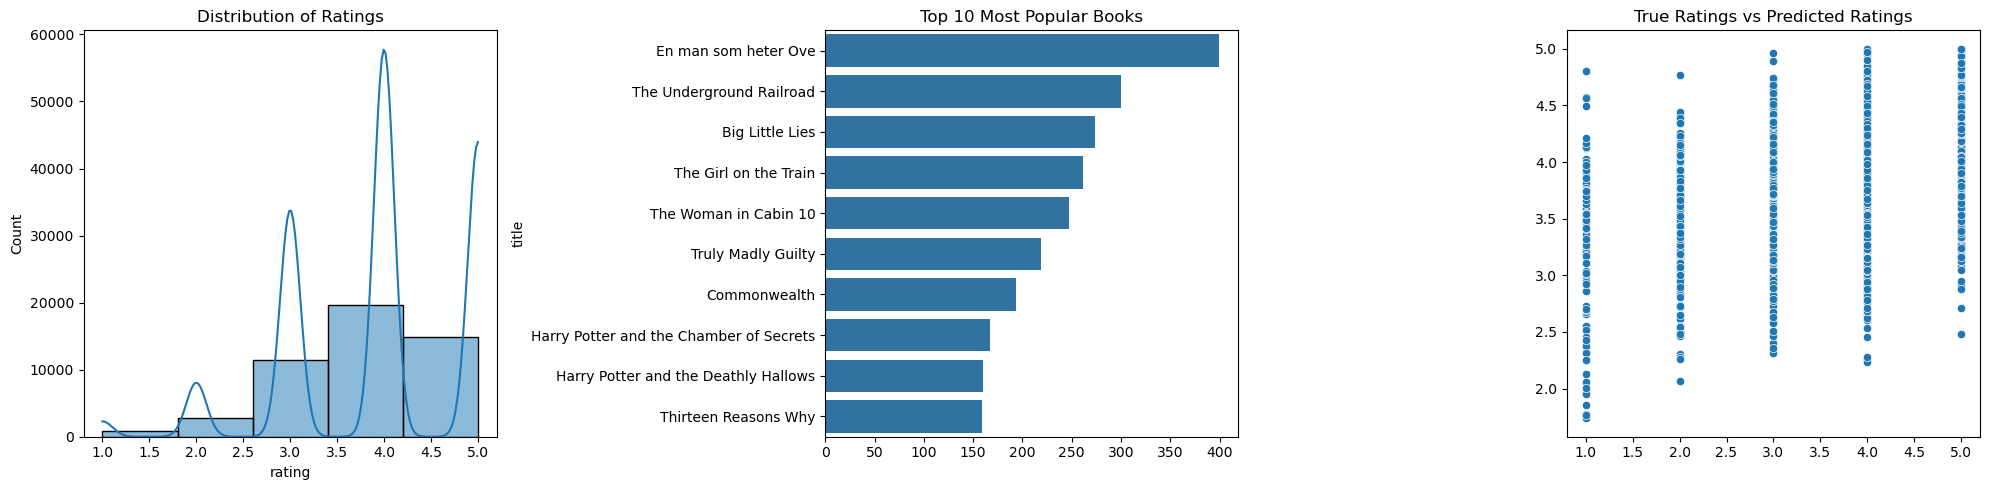

In [20]:
# DataPreparationAndVisualization.ipynb

import pandas as pd
from surprise import Dataset, Reader, SVD
from surprise.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns

# Data Preparation
df = pd.read_csv('/Users/medirose/Documents/GitHub/BookRecommendationProject/cleaned.csv')

# Ensure correct data types
df['user_id'] = df['user_id'].astype(int)
df['book_id'] = df['book_id'].astype(int)
df['gr_book_id'] = df['gr_book_id'].astype(int)
df['books_count'] = df['books_count'].astype(int)
df['year'] = df['year'].astype(int)
df['rating'] = df['rating'].astype(int)
df['ratings_count'] = df['ratings_count'].astype(int)

# Check for missing values in 'title', 'authors', 'isbn', and 'genre' columns
df = df.dropna(subset=['title', 'authors', 'isbn', 'genre'])

# Recommendation Engine
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(df[['user_id', 'book_id', 'rating']], reader)

trainset, testset = train_test_split(data, test_size=0.2)
algo = SVD()
algo.fit(trainset)
predictions = algo.test(testset)

# Evaluation Metrics
y_true = [pred.r_ui for pred in predictions]
y_pred = [pred.est for pred in predictions]

mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)
rmse = mean_squared_error(y_true, y_pred, squared=False)

print(f"MAE: {mae}")
print(f"R2: {r2}")
print(f"RMSE: {rmse}")

# Visualizations
def plot_distributions():
    fig, ax = plt.subplots(1, 3, figsize=(20, 5))

    sns.histplot(df['rating'], bins=5, kde=True, ax=ax[0])
    ax[0].set_title('Distribution of Ratings')

    top_books = df['title'].value_counts().head(10)
    sns.barplot(x=top_books.values, y=top_books.index, ax=ax[1])
    ax[1].set_title('Top 10 Most Popular Books')

    sns.scatterplot(x=y_true, y=y_pred, ax=ax[2])
    ax[2].set_title('True Ratings vs Predicted Ratings')

    plt.tight_layout()
    plt.show()  # Explicitly show the plots only once

# Call the function to display the visualizations
plot_distributions()

THE CODES USED TO RUN STREAMLIT FOR THE INTERACTIVE APP.PY FILE AND CODE

1)   cd /Users/medirose/Documents/GitHub/BookRecommendationProject
2)   ./setup.sh
3)   streamlit run app.py